In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns


In [2]:
np.random.seed(42)
tf.random.set_seed(42)


In [3]:
# Define the image size
IMAGE_SIZE = [224, 224]


In [4]:
# Set the paths to the training and validation data
train_path = 'chest_xray/train'
valid_path = 'chest_xray/test'

In [7]:
# Import the Xception model
xception = Xception(input_shape=IMAGE_SIZE + [3], include_top=False, weights=None)

weights_path = '/Users/hemu/Desktop/Updated_work_on_Deep_Learning/Research_work_on_Deep_Learning/Pneumonia/chest_xray/Pneumonia_models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
xception.load_weights(weights_path)


In [8]:
# Freeze all layers in the Xception model
for layer in xception.layers:
    layer.trainable = False


In [9]:
# Get the folders in the training data directory
folders = glob('chest_xray/train/*')


In [12]:
# Add a global average pooling layer and a dense layer to the Xception model
x = GlobalAveragePooling2D()(xception.output)
prediction = Dense(len(folders), activation='softmax')(x)


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D

In [13]:
# Create a model object
model = Model(inputs=xception.input, outputs=prediction)

In [14]:
# View the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

In [15]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [16]:
# Create image data generators for the training and validation data
train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
# Generate training and validation data
training_set = train_datagen.flow_from_directory('chest_xray/train',
                                                target_size=(224, 224),
                                                batch_size=10,
                                                class_mode='categorical')

test_set = test_datagen.flow_from_directory('chest_xray/test',
                                            target_size=(224, 224),
                                            batch_size=10,
                                            class_mode='categorical')


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [18]:
# Train the model
model.fit(
    training_set,
    validation_data=test_set,
    epochs=1,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)

522/522 [==============================] - 220s 419ms/step - loss: 0.2082 - accuracy: 0.9168 - val_loss: 0.3501 - val_accuracy: 0.8413


In [19]:
# Prediction for a single image
img = image.load_img('chest_xray/test/Normal/IM-0001-0001.jpeg', target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
result = int(classes[0][0])

if result == 0:
    print("Person is Affected By PNEUMONIA")
else:
    print("Result is Normal")

1/1 [==============================] - 0s 491ms/step
Person is Affected By PNEUMONIA


In [20]:
# Initialize an empty list to store true and predicted labels
true_labels = []
predicted_labels = []

In [22]:
# Loop through the test set and predict labels
for i in range(len(test_set)):
    batch = test_set[i]
    images, labels = batch
    predictions = model.predict(images)

    # Convert one-hot encoded labels to class labels
    true_labels.extend(np.argmax(labels, axis=1))
    predicted_labels.extend(np.argmax(predictions, axis=1))


1/1 [==============================] - 0s 158ms/step


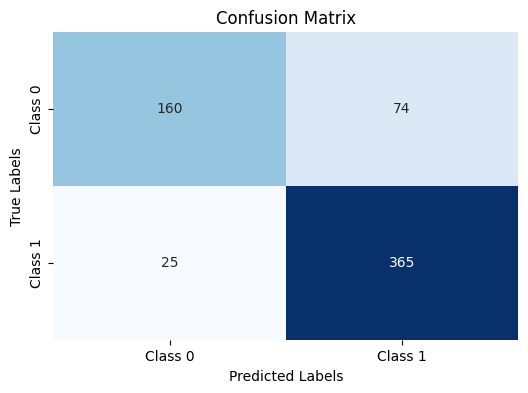

In [23]:
# Calculate the confusion matrix, accuracy, precision, recall, and F1-score

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(conf_matrix)) + 0.5, ['Class 0', 'Class 1'])  # Modify class labels accordingly
plt.yticks(np.arange(len(conf_matrix)) + 0.5, ['Class 0', 'Class 1'])  # Modify class labels accordingly
plt.show()

In [24]:
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy   :", accuracy)
precision = precision_score(true_labels, predicted_labels)
print("Precision :", precision)
recall = recall_score(true_labels, predicted_labels)
print("Recall    :", recall)
F1_score = f1_score(true_labels, predicted_labels)
print("F1-score  :", F1_score)

Accuracy   : 0.8413461538461539
Precision : 0.8314350797266514
Recall    : 0.9358974358974359
F1-score  : 0.8805790108564536
